In [1]:
# --- Plot the Delta shapefile on a folium basemap + (optional) compute monthly ET over the Delta in EE ---

from pathlib import Path
import pandas as pd
import geopandas as gpd
import folium

import ee
from IPython.display import display

# -------------------------
# CONFIG
# -------------------------
delta_shp = Path("../data/regions/Delta_UCB_WGS84/Delta_UCB_WGS84.shp")
assert delta_shp.exists(), f"Not found: {delta_shp.resolve()}"

START = "2000-01-01"  # set to "2012-01-01" 
# Use first day of next month so there is ALWAYS at least one full monthly bin
END = (pd.Timestamp.today().normalize() + pd.offsets.MonthBegin(1)).strftime("%Y-%m-%d")

# Toggle ET computation (folium-only vs folium + EE)
RUN_EE_ET = True

# -------------------------
# 1) Load shapefile (WGS84) + folium basemap
# -------------------------
gdf = gpd.read_file(delta_shp).to_crs(epsg=4326)
if gdf.empty:
    raise ValueError(f"Shapefile has no features: {delta_shp}")

delta_union = gdf.unary_union
centroid = delta_union.centroid

m = folium.Map(location=[centroid.y, centroid.x], zoom_start=8, tiles=None)

folium.TileLayer("OpenStreetMap", name="OpenStreetMap").add_to(m)
folium.TileLayer("CartoDB positron", name="Carto Positron").add_to(m)
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri World Imagery",
    overlay=False,
    control=True,
).add_to(m)

folium.GeoJson(
    gdf.__geo_interface__,
    name="Delta polygon",
    style_function=lambda feat: {
        "color": "yellow",
        "weight": 3,
        "fillColor": "yellow",
        "fillOpacity": 0.1,
    },
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

display(m)



In [2]:
# -------------------------
# 2) Earth Engine monthly ET over the delta (chunked to avoid 429 errors)
# -------------------------
# ee.Authenticate()  # run once per environment if needed
ee.Initialize()

delta_geom = ee.Geometry(delta_union.__geo_interface__)
delta_area_m2 = float(delta_geom.area(maxError=1).getInfo())
print("BBox area (km^2):", delta_area_m2 / 1e6)

# bbox = (min_lon, min_lat, max_lon, max_lat)
okavango_bbox = (19.0, -21.8, 24.8, -17.0)

# Use bbox as the region geometry
delta_geom = ee.Geometry.Rectangle(
    [okavango_bbox[0], okavango_bbox[1], okavango_bbox[2], okavango_bbox[3]],
    proj="EPSG:4326",
    geodesic=True
)

delta_area_m2 = float(delta_geom.area(maxError=1).getInfo())
print("BBox area (km^2):", delta_area_m2 / 1e6)


def monthly_sequence(start_date: str, end_date: str) -> ee.List:
    start = ee.Date(start_date)
    end = ee.Date(end_date)
    n_months = end.difference(start, "month").toInt()
    return ee.List.sequence(0, n_months.subtract(1))

def make_monthly_et_ic(ic: ee.ImageCollection, to_mm_fn, start_date: str, end_date: str) -> ee.ImageCollection:
    """
    Monthly ImageCollection with band 'et_mm' (mm/month) from an input collection.
    Sets system:index = YYYYMM so toBands has clean names.
    """
    start = ee.Date(start_date)
    end = ee.Date(end_date)
    n_months = end.difference(start, "month").toInt()

    def month_img(m):
        m = ee.Number(m)
        m0 = start.advance(m, "month")
        m1 = m0.advance(1, "month")
        sub = ic.filterDate(m0, m1).map(to_mm_fn)

        mm = ee.Image(ee.Algorithms.If(sub.size().gt(0), sub.sum(), ee.Image.constant(0)))
        return (mm.rename("et_mm")
                  .set({
                      "system:time_start": m0.millis(),
                      "system:index": m0.format("YYYYMM"),   # critical for toBands naming
                      "ym": m0.format("YYYY-MM")
                  }))

    months = ee.List(ee.Algorithms.If(n_months.gt(0), monthly_sequence(start_date, end_date), ee.List([])))
    return ee.ImageCollection.fromImages(months.map(month_img))

def monthly_totals_m3_chunked(monthly_ic: ee.ImageCollection, region: ee.Geometry, scale_m: int,
                              chunk_months: int = 24, tile_scale: int = 8) -> dict:
    """
    Returns dict: { 'YYYYMM_et_m3': total_m3_over_region, ... }
    Uses chunked toBands+reduceRegion to avoid "Too many concurrent aggregations".
    """
    n = int(monthly_ic.size().getInfo())
    if n == 0:
        return {}

    imgs = monthly_ic.toList(n)
    out = {}

    for i in range(0, n, chunk_months):
        sub = ee.ImageCollection.fromImages(imgs.slice(i, min(i + chunk_months, n)))

        def to_m3(img):
            img = ee.Image(img)
            idx = ee.String(img.get("system:index"))
            et_m3 = (img.select("et_mm")
                       .unmask(0)
                       .divide(1000)
                       .multiply(ee.Image.pixelArea())
                       .rename("et_m3"))
            return et_m3.set("system:index", idx)

        bands_img = sub.map(to_m3).toBands()

        d = bands_img.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=region,
            scale=scale_m,
            maxPixels=1e13,
            tileScale=tile_scale
        ).getInfo()

        out.update(d)

    return out

def totals_dict_to_df(totals: dict, dataset_name: str, area_m2: float) -> pd.DataFrame:
    """
    Parse {'YYYYMM_et_m3': val, ...} -> DataFrame with date, et_km3_total, et_mm_mean
    """
    rows = []
    for k, v in totals.items():
        # k looks like: "200001_et_m3"
        yyyymm = k.split("_")[0]
        date = pd.to_datetime(yyyymm + "01", format="%Y%m%d")
        total_m3 = float(v) if v is not None else 0.0
        rows.append({
            "dataset": dataset_name,
            "date": date,
            "et_km3_total": total_m3 / 1e9,
            "et_mm_mean": (total_m3 / area_m2) * 1000.0
        })
    df = pd.DataFrame(rows).sort_values("date").reset_index(drop=True)
    return df

# -------------------------
# Converters to mm per native timestep (then monthly sum happens in make_monthly_et_ic)
# -------------------------
def mod16_mm(img):
    return img.select("ET").multiply(0.1)  # kg/m^2 per 8-day -> mm per 8-day (scale 0.1)

def terraclimate_mm(img):
    return img.select("aet").multiply(0.1)  # mm/month (scale 0.1)

def fldas_mm(img):
    d0 = ee.Date(img.get("system:time_start"))
    seconds = d0.advance(1, "month").difference(d0, "second")
    return img.select("Evap_tavg").multiply(seconds)  # kg/m^2/s * s -> kg/m^2 -> mm/month

def era5_land_mm(img):
    return img.select("total_evaporation_sum").multiply(-1000)  # m -> mm; sign flip (evap is negative)

def pml_mm(img):
    et_mmday = img.select(["Ec", "Es", "Ei"]).reduce(ee.Reducer.sum())  # mm/day
    return et_mmday.multiply(8)  # approx mm per 8-day composite

def wapor_mm(img):
    d0 = ee.Date(img.get("system:time_start"))
    d1_candidate = d0.advance(10, "day")
    month_end = ee.Date.fromYMD(d0.get("year"), d0.get("month"), 1).advance(1, "month")
    d1 = ee.Date(ee.Algorithms.If(d1_candidate.millis().lte(month_end.millis()), d1_candidate, month_end))
    days = d1.difference(d0, "day")
    return img.select("L1-AETI-D").multiply(0.1).multiply(days)  # (mm/day)*days

DATASETS = [
    dict(name="MOD16A2GF_v61", id="MODIS/061/MOD16A2GF", to_mm=mod16_mm, scale=500,  start="2000-01-01"),
    dict(name="PML_v2_landET", id="CAS/IGSNRR/PML/V2_v018", to_mm=pml_mm, scale=500, start="2000-01-01"),
    dict(name="TerraClimate_aet", id="IDAHO_EPSCOR/TERRACLIMATE", to_mm=terraclimate_mm, scale=4638, start="1958-01-01"),
    dict(name="FLDAS_Evap", id="NASA/FLDAS/NOAH01/C/GL/M/V001", to_mm=fldas_mm, scale=11132, start="1982-01-01"),
    dict(name="ERA5Land_totalET", id="ECMWF/ERA5_LAND/MONTHLY_AGGR", to_mm=era5_land_mm, scale=11132, start="1950-02-01"),
    dict(name="USGS_SSEBop_MODIS_monthly",
         id="projects/earthengine-legacy/assets/projects/usgs-ssebop/modis_et_v5_monthly",
         to_mm=lambda img: img.select("et"),
         scale=1000,
         start="2003-01-01"),
    dict(name="WaPORv3_AETI_dekadal", id="FAO/WAPOR/3/L1_AETI_D", to_mm=wapor_mm, scale=248, start="2018-01-01"),
]

# -------------------------
# Run all datasets
# -------------------------
dfs = []
for ds in DATASETS:
    start = max(pd.to_datetime(START), pd.to_datetime(ds["start"])).strftime("%Y-%m-%d")
    if pd.to_datetime(start) >= pd.to_datetime(END):
        print(f"Skipping {ds['name']}: start >= END ({start} >= {END})")
        continue

    ic = (ee.ImageCollection(ds["id"])
          .filterBounds(delta_geom)
          .filterDate(start, END))

    monthly_ic = make_monthly_et_ic(ic, ds["to_mm"], start, END)
    n_months = int(monthly_ic.size().getInfo())
    print(f"{ds['name']}: monthly bins = {n_months} | start={start} end={END}")

    totals = monthly_totals_m3_chunked(monthly_ic, delta_geom, scale_m=ds["scale"], chunk_months=24, tile_scale=8)
    df_ds = totals_dict_to_df(totals, ds["name"], area_m2=delta_area_m2)
    dfs.append(df_ds)

df_all = pd.concat(dfs, ignore_index=True).sort_values(["dataset", "date"]).reset_index(drop=True)



BBox area (km^2): 23387.353532158686
BBox area (km^2): 324769.432857613
MOD16A2GF_v61: monthly bins = 313 | start=2000-01-01 end=2026-03-01


/Users/octaviacrompton/anaconda3/envs/ee-map/lib/python3.11/site-packages/ee/deprecation.py:209: DeprecationWarning: 

Attention required for CAS/IGSNRR/PML/V2_v018! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/CAS_IGSNRR_PML_V2_v018

  warnings.warn(warning, category=DeprecationWarning)


PML_v2_landET: monthly bins = 313 | start=2000-01-01 end=2026-03-01
TerraClimate_aet: monthly bins = 313 | start=2000-01-01 end=2026-03-01
FLDAS_Evap: monthly bins = 313 | start=2000-01-01 end=2026-03-01
ERA5Land_totalET: monthly bins = 313 | start=2000-01-01 end=2026-03-01
USGS_SSEBop_MODIS_monthly: monthly bins = 277 | start=2003-01-01 end=2026-03-01
WaPORv3_AETI_dekadal: monthly bins = 97 | start=2018-01-01 end=2026-03-01


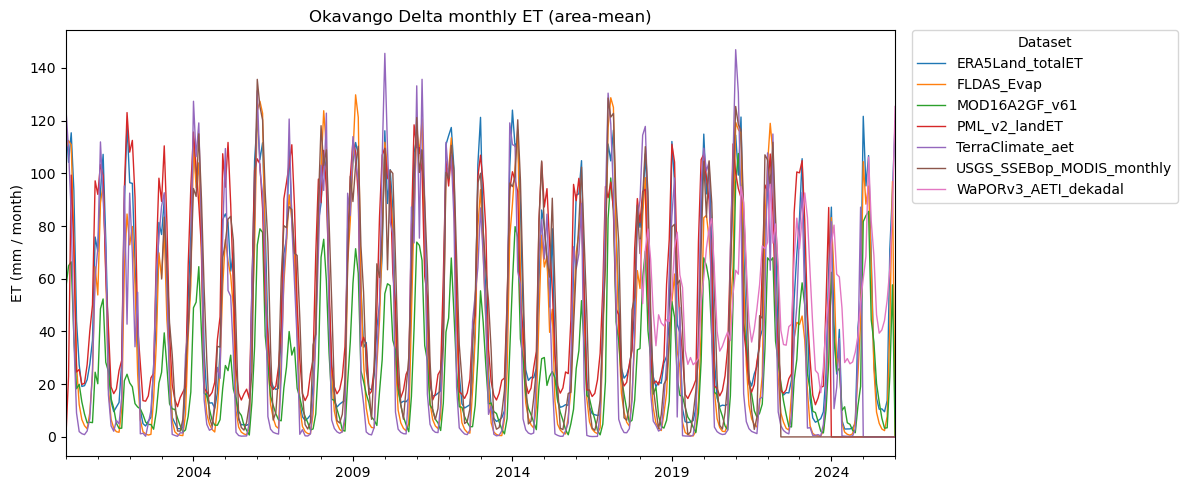

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime
df = df_all.copy()
df["date"] = pd.to_datetime(df["date"])

#  restrict to 2012+
# df = df[df["date"] >= "2012-01-01"]

# --- Plot 1: area-mean ET (mm/month) ---
wide_mm = (df.pivot_table(index="date", columns="dataset", values="et_mm_mean", aggfunc="mean")
             .sort_index())

fig, ax = plt.subplots(figsize=(12, 5))
wide_mm.plot(ax=ax, linewidth=1)
ax.set_title("Okavango Delta monthly ET (area-mean)")
ax.set_ylabel("ET (mm / month)")
ax.set_xlabel("")
ax.legend(title="Dataset", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()


In [4]:
df_all['month'] = df_all.date.dt.month

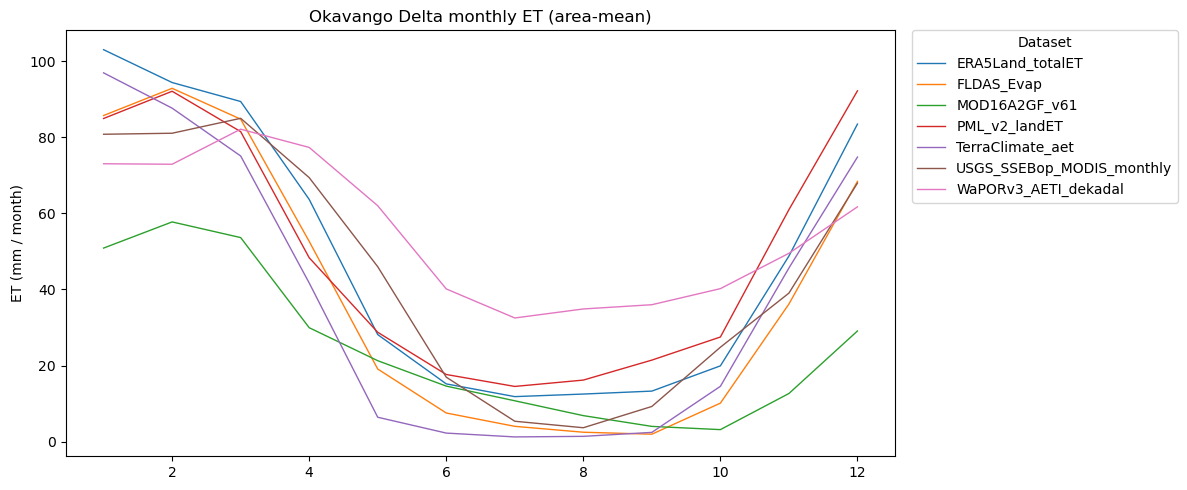

In [5]:
# --- Plot 1: area-mean ET (mm/month) ---
wide_mm = (df_all.pivot_table(index="month", columns="dataset", values="et_mm_mean", aggfunc="mean")
             .sort_index())

fig, ax = plt.subplots(figsize=(12, 5))
wide_mm.plot(ax=ax, linewidth=1)
ax.set_title("Okavango Delta monthly ET (area-mean)")
ax.set_ylabel("ET (mm / month)")
ax.set_xlabel("")
ax.legend(title="Dataset", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()


In [6]:
from pathlib import Path
import geopandas as gpd
import pandas as pd
import ee

# -------------------------
# CONFIG
# -------------------------
# delta_shp = Path("../data/regions/Delta_UCB_WGS84/Delta_UCB_WGS84.shp")
# assert delta_shp.exists(), f"Not found: {delta_shp.resolve()}"

START = "2000-01-01"  # or "2012-01-01"
END = (pd.Timestamp.today().normalize() + pd.offsets.MonthBegin(1)).strftime("%Y-%m-%d")

OUTDIR = Path("../data/chirps")
OUTDIR.mkdir(parents=True, exist_ok=True)

# -------------------------
# EE init
# -------------------------
# ee.Authenticate()  # run once per environment if needed
ee.Initialize()

# -------------------------
# Load delta geometry
# -------------------------
# gdf = gpd.read_file(delta_shp).to_crs(epsg=4326)
# delta_union = gdf.unary_union
# delta_geom = ee.Geometry(delta_union.__geo_interface__)
# delta_area_m2 = float(delta_geom.area(maxError=1).getInfo())

# -------------------------
# Helpers
# -------------------------
def monthly_sequence(start_date: str, end_date: str) -> ee.List:
    start = ee.Date(start_date)
    end = ee.Date(end_date)
    n_months = end.difference(start, "month").toInt()
    return ee.List.sequence(0, n_months.subtract(1))

def make_monthly_from_daily(daily_ic: ee.ImageCollection, band: str, start_date: str, end_date: str) -> ee.ImageCollection:
    """
    Sum daily precipitation into monthly totals (mm/month).
    """
    start = ee.Date(start_date)
    end = ee.Date(end_date)
    n_months = end.difference(start, "month").toInt()

    def month_img(m):
        m = ee.Number(m)
        m0 = start.advance(m, "month")
        m1 = m0.advance(1, "month")
        sub = daily_ic.filterDate(m0, m1).select(band)

        mm = ee.Image(ee.Algorithms.If(sub.size().gt(0), sub.sum(), ee.Image.constant(0)))
        return (mm.rename("ppt_mm")
                  .set({
                      "system:time_start": m0.millis(),
                      "system:index": m0.format("YYYYMM"),
                      "ym": m0.format("YYYY-MM")
                  }))

    months = ee.List(ee.Algorithms.If(n_months.gt(0), monthly_sequence(start_date, end_date), ee.List([])))
    return ee.ImageCollection.fromImages(months.map(month_img))

def collection_depth_to_totals_dict(ic: ee.ImageCollection,
                                    band: str,
                                    date_fmt: str,
                                    region: ee.Geometry,
                                    scale_m: int,
                                    chunk_n: int,
                                    tile_scale: int = 8) -> dict:
    """
    Reduce an ImageCollection of depth images (mm per image) to a dict of total m3 over region.
    Returns keys like 'YYYYMM_ppt_m3' or 'YYYYMMdd_ppt_m3'.
    """
    n = int(ic.size().getInfo())
    if n == 0:
        return {}

    imgs = ic.toList(n)
    out = {}

    def prep(img):
        img = ee.Image(img)
        d = ee.Date(img.get("system:time_start"))
        idx = d.format(date_fmt)
        m3 = (img.select(band)
                .unmask(0)
                .divide(1000)  # mm -> m
                .multiply(ee.Image.pixelArea())
                .rename("ppt_m3"))
        return m3.set("system:index", idx)

    for i in range(0, n, chunk_n):
        sub = ee.ImageCollection.fromImages(imgs.slice(i, min(i + chunk_n, n))).map(prep)
        bands_img = sub.toBands()  # band names become YYYYMM_ppt_m3 etc.

        dct = bands_img.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=region,
            scale=scale_m,
            maxPixels=1e13,
            tileScale=tile_scale
        ).getInfo()

        out.update(dct)

    return out

def totals_dict_to_df(totals: dict, date_parse: str, dataset_name: str, area_m2: float) -> pd.DataFrame:
    """
    totals keys like 'YYYYMM_ppt_m3' -> date, ppt_km3_total, ppt_mm_mean
    """
    rows = []
    for k, v in totals.items():
        ymd = k.split("_")[0]
        date = pd.to_datetime(ymd + ("01" if date_parse == "%Y%m" else ""), format=date_parse + ("" if date_parse != "%Y%m" else "%d"))
        total_m3 = float(v) if v is not None else 0.0
        rows.append({
            "dataset": dataset_name,
            "date": date,
            "ppt_km3_total": total_m3 / 1e9,
            "ppt_mm_mean": (total_m3 / area_m2) * 1000.0
        })
    df = pd.DataFrame(rows).sort_values("date").reset_index(drop=True)
    return df

# -------------------------
# 1) CHIRPS MONTHLY over delta
# -------------------------
# Option A (preferred if available): monthly collection directly
#   monthly_id = "UCSB-CHG/CHIRPS/MONTHLY"
# Option B (always works): make monthly from CHIRPS daily
daily_id = "UCSB-CHG/CHIRPS/DAILY"
band_daily = "precipitation"

chirps_daily = (ee.ImageCollection(daily_id)
                .filterBounds(delta_geom)
                .filterDate(START, END))

chirps_monthly = make_monthly_from_daily(chirps_daily, band_daily, START, END)  # mm/month in band 'ppt_mm'

tot_m = collection_depth_to_totals_dict(
    ic=chirps_monthly,
    band="ppt_mm",
    date_fmt="YYYYMM",
    region=delta_geom,
    scale_m=5500,     # CHIRPS ~0.05° (~5km)
    chunk_n=120,      # months per request (10 years)
    tile_scale=8
)

df_chirps_monthly = totals_dict_to_df(tot_m, date_parse="%Y%m", dataset_name="CHIRPS_monthly", area_m2=delta_area_m2)
out_monthly = OUTDIR / "chirps_delta_monthly.csv"
df_chirps_monthly.to_csv(out_monthly, index=False)
print("Saved:", out_monthly, "| rows:", len(df_chirps_monthly))

# -------------------------
# 2)  CHIRPS DAILY over delta
# -------------------------
# Uncomment for daily series; consider START="2012-01-01" to keep it lighter.

# def add_index(img):
#     d = ee.Date(img.get("system:time_start"))
#     return ee.Image(img).set("system:index", d.format("YYYYMMdd"))
#
# chirps_daily_idx = chirps_daily.map(add_index)
#
# tot_d = collection_depth_to_totals_dict(
#     ic=chirps_daily_idx.select(band_daily),
#     band=band_daily,
#     date_fmt="YYYYMMdd",
#     region=delta_geom,
#     scale_m=5500,
#     chunk_n=180,     # ~6 months per request (keeps bands reasonable)
#     tile_scale=8
# )
#
# df_chirps_daily = totals_dict_to_df(tot_d, date_parse="%Y%m%d", dataset_name="CHIRPS_daily", area_m2=delta_area_m2)
# out_daily = OUTDIR / "chirps_delta_daily.csv"
# df_chirps_daily.to_csv(out_daily, index=False)
# print("Saved:", out_daily, "| rows:", len(df_chirps_daily))


Saved: ../data/chirps/chirps_delta_monthly.csv | rows: 313


In [7]:
df_chirps_monthly

,dataset,date,ppt_km3_total,ppt_mm_mean
0,CHIRPS_monthly,2000-01-01,58.426494,179.901455
1,CHIRPS_monthly,2000-02-01,53.444849,164.562437
2,CHIRPS_monthly,2000-03-01,35.130058,108.169226
3,CHIRPS_monthly,2000-04-01,6.290645,19.369572
4,CHIRPS_monthly,2000-05-01,0.016077,0.049501
...,...,...,...,...
308,CHIRPS_monthly,2025-09-01,0.187361,0.576905
309,CHIRPS_monthly,2025-10-01,3.592728,11.062395
310,CHIRPS_monthly,2025-11-01,16.452436,50.658819
311,CHIRPS_monthly,2025-12-01,63.150026,194.445719


<Axes: title={'center': 'Okavango Delta monthly ET (area-mean)'}, xlabel='date', ylabel='ET (mm / month)'>

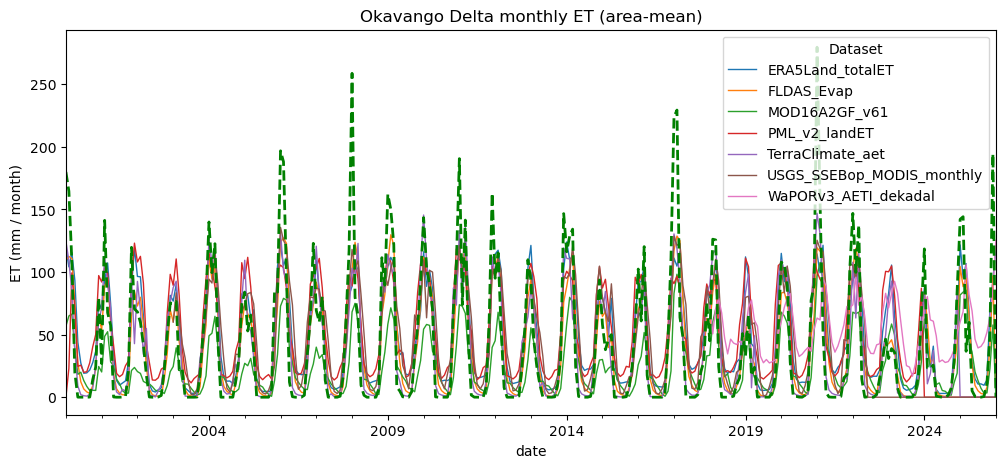

In [8]:

# --- Plot 1: area-mean ET (mm/month) ---
wide_mm = (df.pivot_table(index="date", columns="dataset", values="et_mm_mean", aggfunc="mean")
             .sort_index())



fig, ax = plt.subplots(figsize=(12, 5))
wide_mm.plot(ax=ax, linewidth=1)
ax.set_title("Okavango Delta monthly ET (area-mean)")
ax.set_ylabel("ET (mm / month)")
ax.set_xlabel("")
ax.legend(title="Dataset", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
# plt.tight_layout()
# plt.show()
df_chirps_monthly.set_index('date')['ppt_mm_mean'].plot(lw = 2, ls = '--', c = 'g')

In [9]:
df_chirps_monthly.head()

,dataset,date,ppt_km3_total,ppt_mm_mean
0,CHIRPS_monthly,2000-01-01,58.426494,179.901455
1,CHIRPS_monthly,2000-02-01,53.444849,164.562437
2,CHIRPS_monthly,2000-03-01,35.130058,108.169226
3,CHIRPS_monthly,2000-04-01,6.290645,19.369572
4,CHIRPS_monthly,2000-05-01,0.016077,0.049501


In [10]:
chirps_mm = df_chirps_monthly.set_index('date')['ppt_mm_mean']

chirps_km3 = df_chirps_monthly.set_index('date')['ppt_km3_total']

<Axes: xlabel='date'>

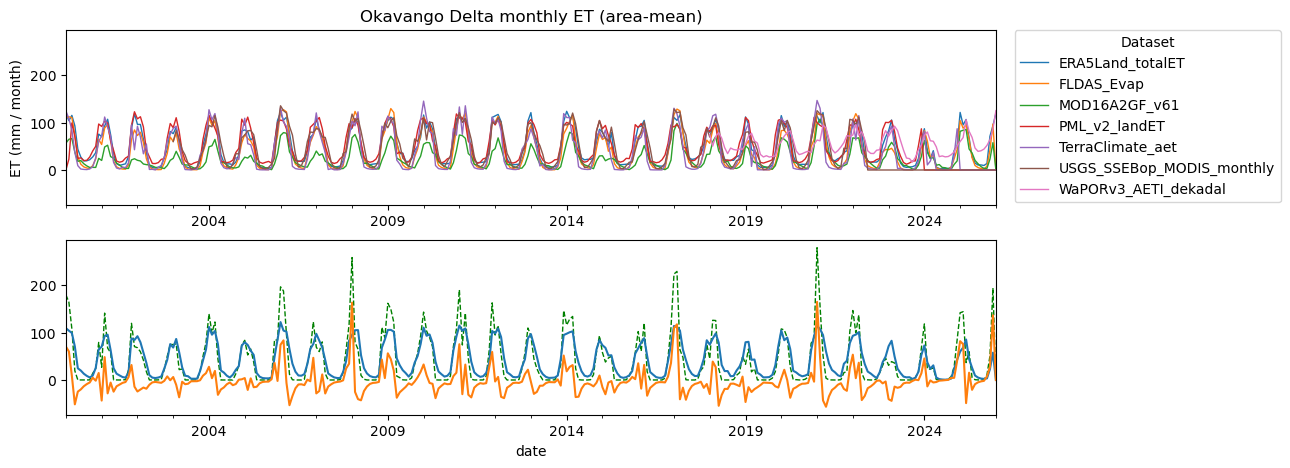

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharey = True)
ax = axes[0]
wide_mm.plot(ax=ax, linewidth=1)
ax.set_title("Okavango Delta monthly ET (area-mean)")
ax.set_ylabel("ET (mm / month)")
ax.set_xlabel("")
ax.legend(title="Dataset", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

chirps_mm.plot(lw = 1, ls = '--', c = 'g')

wide_mm.median(1).plot(ls = '-', c = 'C0')
(chirps_mm - wide_mm.median(1)).plot(c = 'C1')

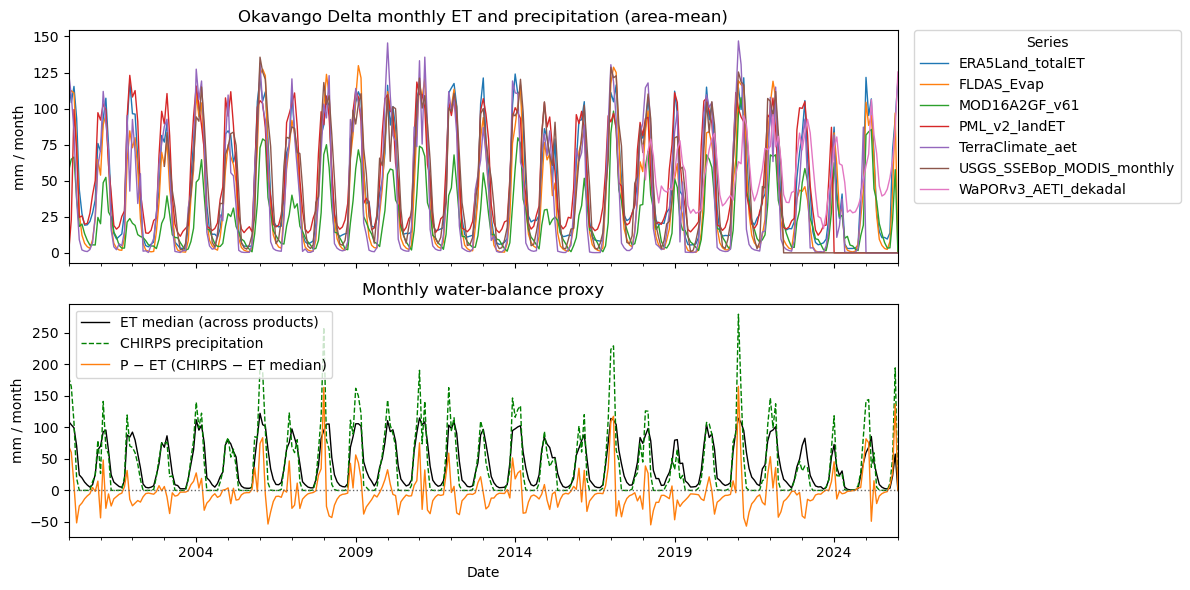

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

start = "2000-01-01"

# --- Slice to common window
wide_mm_2012 = wide_mm.loc[pd.to_datetime(start):]
et_med = wide_mm_2012.median(axis=1)

chirps_mm = (df_chirps_monthly
             .assign(date=pd.to_datetime(df_chirps_monthly["date"]))
             .set_index("date")["ppt_mm_mean"]
             .loc[pd.to_datetime(start):])

# Align indexes before differencing
chirps_mm_aligned, et_med_aligned = chirps_mm.align(et_med, join="inner")
p_minus_et = chirps_mm_aligned - et_med_aligned

# --- Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)  # sharey=False is usually better here
ax0, ax1 = axes

# Panel 1: ET datasets + ET median + CHIRPS precip
wide_mm_2012.plot(ax=ax0, linewidth=1)
et_med.plot(ax=ax1, lw=1, c="k", label="ET median (across products)")
chirps_mm.plot(ax=ax1, lw=1, ls="--", c="g", label="CHIRPS precipitation")

ax0.set_title("Okavango Delta monthly ET and precipitation (area-mean)")
ax0.set_ylabel("mm / month")
ax0.set_xlabel("")
ax0.legend(title="Series", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

# Panel 2: P - ET
p_minus_et.plot(ax=ax1, lw=1, c="C1", label="P − ET (CHIRPS − ET median)")
ax1.axhline(0, lw=1, ls=":", c="0.4")

ax1.set_title("Monthly water-balance proxy")
ax1.set_ylabel("mm / month")
ax1.set_xlabel("Date")
ax1.legend(loc="upper left")

plt.tight_layout()
plt.show()


In [35]:
wide_mm_2012.head()
# 'WaPORv3_AETI_dekadal'

dataset,ERA5Land_totalET,FLDAS_Evap,MOD16A2GF_v61,PML_v2_landET,TerraClimate_aet,USGS_SSEBop_MODIS_monthly,WaPORv3_AETI_dekadal
date,,,,,,,
2000-01-01,119.320636,109.476416,56.754732,0.000000,124.707942,NaN,NaN
2000-02-01,104.184302,112.422520,64.915015,23.007068,108.864255,NaN,NaN
2000-03-01,115.387445,110.828028,66.407764,99.346072,84.622984,NaN,NaN
2000-04-01,93.404011,74.518210,37.813600,70.783747,37.033633,NaN,NaN
2000-05-01,43.923626,27.314043,18.277825,24.634498,9.063979,NaN,NaN


In [73]:
import pandas as pd
import numpy as np

ssebop = "USGS_SSEBop_MODIS_monthly"
tiny = 1e-6  # km3 or mm threshold for "effectively zero"

m = df_all["dataset"].eq(ssebop)

# Find last month with a non-trivial value (before we blank zeros)
last_valid = df_all.loc[m & (df_all["et_km3_total"] > tiny), "date"].max()
print("SSEBop last nonzero month:", last_valid)

# 1) Convert zeros/tiny values to NaN (missing)
df_all.loc[m & (df_all["et_km3_total"] <= tiny), "et_km3_total"] = np.nan
df_all.loc[m & (df_all["et_mm_mean"]   <= tiny), "et_mm_mean"]   = np.nan

# 2) Optional: if it truly stops after last_valid, blank everything after that month too
if pd.notna(last_valid):
    df_all.loc[m & (df_all["date"] > last_valid), ["et_km3_total", "et_mm_mean"]] = np.nan
    
    
# Ensure datetime
df_et = df_all.copy()
df_et["date"] = pd.to_datetime(df_et["date"])

df_p = df_chirps_monthly.copy()
df_p["date"] = pd.to_datetime(df_p["date"])

# 1) Pivot ET wide (one column per dataset)
et_mm_wide  = df_et.pivot_table(index="date", columns="dataset", values="et_mm_mean",  aggfunc="median")
et_km3_wide = df_et.pivot_table(index="date", columns="dataset", values="et_km3_total", aggfunc="median")

# 2) Pivot precip wide (in case you later add multiple precip products)
p_mm_wide  = df_p.pivot_table(index="date", columns="dataset", values="ppt_mm_mean",  aggfunc="median")
p_km3_wide = df_p.pivot_table(index="date", columns="dataset", values="ppt_km3_total", aggfunc="median")

# 3) Flatten column names and join
et_mm_wide.columns  = [f"ETmm_{c}" for c in et_mm_wide.columns]
et_km3_wide.columns = [f"ETkm3_{c}" for c in et_km3_wide.columns]
p_mm_wide.columns   = [f"Pmm_{c}" for c in p_mm_wide.columns]
p_km3_wide.columns  = [f"Pkm3_{c}" for c in p_km3_wide.columns]

df_combined = pd.concat([et_mm_wide, et_km3_wide, p_mm_wide, p_km3_wide], axis=1).sort_index()

# Optional: keep only overlap period across all columns
# df_combined = df_combined.dropna(how="any")

df_combined.reset_index(inplace=True)
df_combined.rename(columns={"index": "date"}, inplace=True)


SSEBop last nonzero month: 2022-05-01 00:00:00


In [ ]:
## df_et.query("dataset == 'USGS_SSEBop_MODIS_monthly'")

In [78]:
et_mm_wide['ETmm_USGS_SSEBop_MODIS_monthly'].dropna()


date
2003-01-01     59.980689
2003-02-01     83.397818
2003-03-01     64.642623
2003-04-01     43.142780
2003-05-01     31.244026
                 ...    
2022-01-01    105.114435
2022-02-01     94.375321
2022-03-01    111.832408
2022-04-01     83.522747
2022-05-01     60.144807
Name: ETmm_USGS_SSEBop_MODIS_monthly, Length: 233, dtype: float64

In [38]:
# import seaborn as sns
# (df_combo.corr()[['Pmm_CHIRPS_monthly']][1:-2])

In [39]:
# --- GRACE (JPL RL06.3 mascon CRI) monthly time series over the Okavango Delta polygon ---
# Produces:
#   df_grace: date, grace_km3_total, grace_cm_mean
# And (optionally) merges into your existing df_combo on date.

from pathlib import Path
import re
import geopandas as gpd
import pandas as pd
import ee

# -------------------------
# CONFIG
# -------------------------
# delta_shp = Path("../data/regions/Delta_UCB_WGS84/Delta_UCB_WGS84.shp")
# assert delta_shp.exists(), f"Not found: {delta_shp.resolve()}"

START = "2002-04-01"  # GRACE starts ~2002
END   = (pd.Timestamp.today().normalize() + pd.offsets.MonthBegin(1)).strftime("%Y-%m-%d")

GRACE_ID = "NASA/GRACE/MASS_GRIDS_V04/MASCON_CRI"   # CRI-filtered JPL mascon (monthly)
BAND = "lwe_thickness"                             # cm equivalent water thickness anomaly

# # -------------------------
# # EE init + geometry
# # -------------------------
# # ee.Authenticate()  # run once per environment if needed
# ee.Initialize()

# gdf = gpd.read_file(delta_shp).to_crs(epsg=4326)
# delta_union = gdf.unary_union
# delta_geom = ee.Geometry(delta_union.__geo_interface__)
# delta_area_m2 = float(delta_geom.area(maxError=1).getInfo())

# -------------------------
# Helpers
# -------------------------
def grace_totals_m3_chunked(grace_ic: ee.ImageCollection,
                            region: ee.Geometry,
                            scale_m: int = 55660,
                            chunk_n: int = 60,
                            tile_scale: int = 8) -> dict:
    """
    Reduce GRACE IC to dict of total m^3 anomaly over region for each monthly image.
    Keys look like 'YYYYMM_tws_m3' (sometimes prefixed like '0_YYYYMM_tws_m3').
    """
    n = int(grace_ic.size().getInfo())
    if n == 0:
        return {}

    imgs = grace_ic.toList(n)
    out = {}

    def prep(img):
        img = ee.Image(img)
        d = ee.Date(img.get("system:time_start"))
        idx = d.format("YYYYMM")

        # lwe_thickness is cm of equivalent water thickness anomaly
        tws_m3 = (img.select(BAND)
                    .unmask(0)
                    .divide(100.0)              # cm -> m
                    .multiply(ee.Image.pixelArea())
                    .rename("tws_m3"))

        return tws_m3.set("system:index", idx)

    for i in range(0, n, chunk_n):
        sub = ee.ImageCollection.fromImages(imgs.slice(i, min(i + chunk_n, n))).map(prep)
        bands_img = sub.toBands()

        dct = bands_img.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=region,
            scale=scale_m,
            maxPixels=1e13,
            tileScale=tile_scale
        ).getInfo()

        out.update(dct)

    return out

def totals_dict_to_df(totals: dict, area_m2: float) -> pd.DataFrame:
    """
    totals keys may contain YYYYMM or YYYYMMDD anywhere (and may have a numeric prefix).
    Returns monthly time series:
      grace_km3_total: km^3 anomaly over region
      grace_cm_mean: area-mean cm anomaly over region
    """
    rows = []
    for k, v in totals.items():
        m = re.search(r"(\d{8}|\d{6})", k)
        if m is None:
            continue
        code = m.group(1)

        if len(code) == 6:      # YYYYMM
            date = pd.to_datetime(code + "01", format="%Y%m%d")
        else:                   # YYYYMMDD
            date = pd.to_datetime(code, format="%Y%m%d")

        total_m3 = float(v) if v is not None else 0.0
        mean_m = total_m3 / area_m2

        rows.append({
            "date": date,
            "grace_km3_total": total_m3 / 1e9,
            "grace_cm_mean": mean_m * 100.0
        })

    return (pd.DataFrame(rows)
              .sort_values("date")
              .reset_index(drop=True))

# -------------------------
# Build GRACE IC + compute
# -------------------------
grace_ic = (ee.ImageCollection(GRACE_ID)
            .filterBounds(delta_geom)
            .filterDate(START, END)
            .select(BAND))

print("GRACE images:", grace_ic.size().getInfo())

totals = grace_totals_m3_chunked(
    grace_ic=grace_ic,
    region=delta_geom,
    scale_m=55660,   # ~55 km mascon grid
    chunk_n=60,      # ~5 years per request; reduce if you get 429
    tile_scale=8     # increase to 16 if you get 429
)

# Optional: inspect a few keys if debugging
print("Example keys:", list(totals.keys())[:8])

df_grace = totals_dict_to_df(totals, area_m2=delta_area_m2)



GRACE images: 238
Example keys: ['20020403_20020429_tws_m3', '20020501_20020517_tws_m3', '20020731_20020830_tws_m3', '20020831_20020929_tws_m3', '20020930_20021030_tws_m3', '20021031_20021129_tws_m3', '20021130_20021230_tws_m3', '20021231_20030130_tws_m3']


In [40]:
# fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharey = False)
# ax = axes[0]
# (chirps_mm - wide_mm.median(1)).plot(c = 'C1', ax = ax, marker = '.', linestyle = ':')
# ax = axes[1]
# df_grace.set_index('date')['grace_cm_mean'].plot(marker = '.', linestyle = ':')

In [41]:
ET_km3 = (df.pivot_table(index="date", columns="dataset", values="et_km3_total", aggfunc="mean")
             .sort_index())

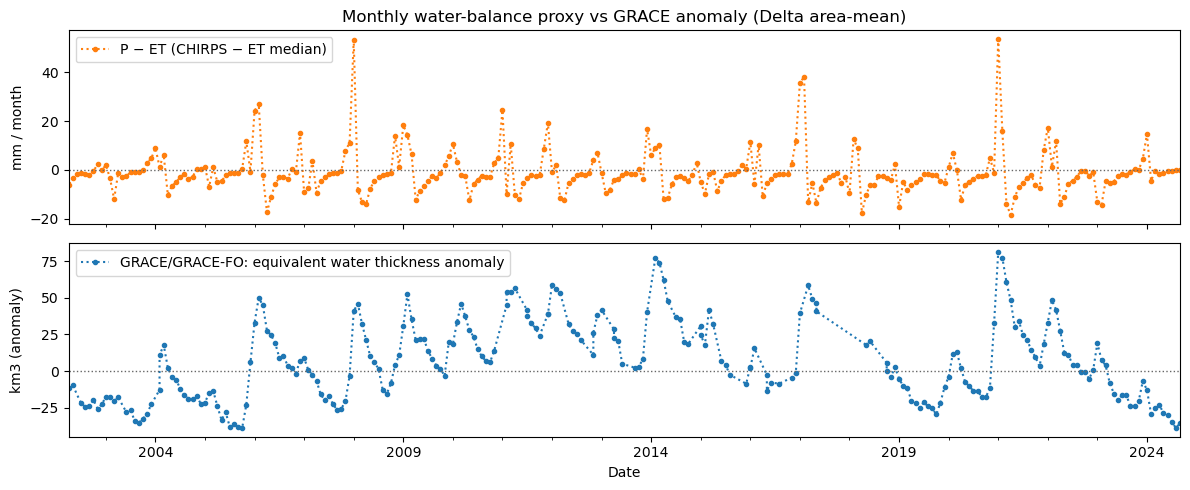

In [42]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True, sharey=False)

# Panel 1: P - ET
ax0 = axes[0]
(chirps_km3 - ET_km3.median(1)).plot(
    ax=ax0, c="C1", marker=".", linestyle=":", label="P − ET (CHIRPS − ET median)"
)
ax0.axhline(0, lw=1, ls=":", c="0.4")
ax0.set_title("Monthly water-balance proxy vs GRACE anomaly (Delta area-mean)")
ax0.set_ylabel("mm / month")
ax0.set_xlabel("")
ax0.legend(loc="upper left")

# Panel 2: GRACE
ax1 = axes[1]
(df_grace.set_index("date")["grace_km3_total"]).plot(
    ax=ax1, marker=".", linestyle=":", label="GRACE/GRACE-FO: equivalent water thickness anomaly"
)
ax1.axhline(0, lw=1, ls=":", c="0.4")
ax1.set_ylabel("km3 (anomaly)")
ax1.set_xlabel("Date")
ax1.legend(loc="upper left")

plt.tight_layout()
plt.show()


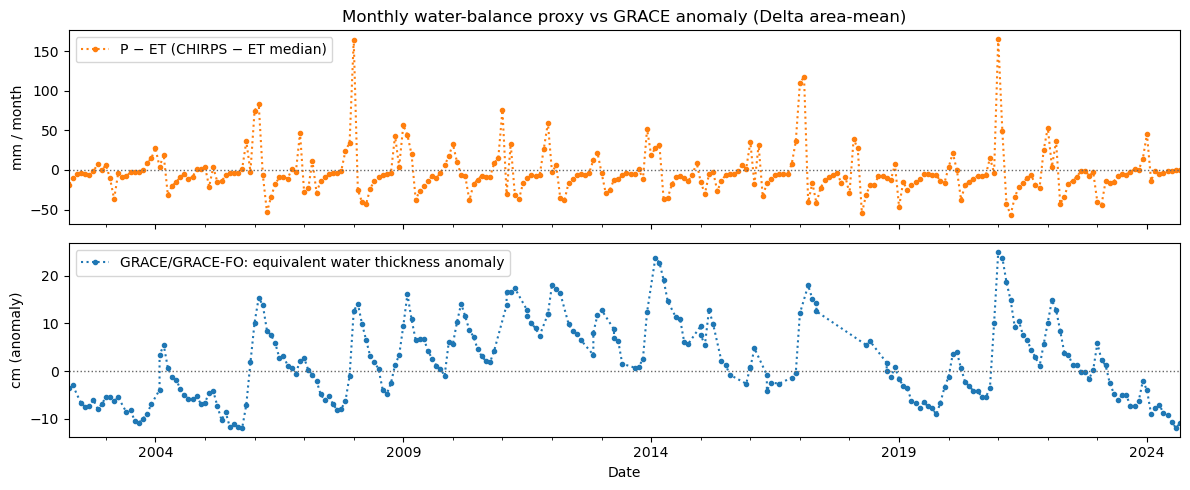

In [43]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True, sharey=False)

# Panel 1: P - ET
ax0 = axes[0]
(chirps_mm - wide_mm.median(1)).plot(
    ax=ax0, c="C1", marker=".", linestyle=":", label="P − ET (CHIRPS − ET median)"
)
ax0.axhline(0, lw=1, ls=":", c="0.4")
ax0.set_title("Monthly water-balance proxy vs GRACE anomaly (Delta area-mean)")
ax0.set_ylabel("mm / month")
ax0.set_xlabel("")
ax0.legend(loc="upper left")

# Panel 2: GRACE
ax1 = axes[1]
(df_grace.set_index("date")["grace_cm_mean"]).plot(
    ax=ax1, marker=".", linestyle=":", label="GRACE/GRACE-FO: equivalent water thickness anomaly"
)
ax1.axhline(0, lw=1, ls=":", c="0.4")
ax1.set_ylabel("cm (anomaly)")
ax1.set_xlabel("Date")
ax1.legend(loc="upper left")

plt.tight_layout()
plt.show()


In [44]:
df_grace.head(10)

,date,grace_km3_total,grace_cm_mean
0,2002-04-03,-11.796774,-3.632354
1,2002-05-01,-9.707394,-2.989011
2,2002-07-31,-21.961086,-6.762055
3,2002-08-31,-24.344153,-7.495826
4,2002-09-30,-23.768982,-7.318725
5,2002-10-31,-19.554778,-6.021126
6,2002-11-30,-25.652165,-7.898577
7,2002-12-31,-22.756444,-7.006954
8,2003-01-31,-17.576062,-5.411858
9,2003-02-28,-17.425167,-5.365396


Station: MOHEMBO/MTAEMBO, GRDC: 1357100, River: OKAVANGO RIVER
Lat/Lon: -18.283333, 21.8
Unit: m³/s, Time series: 1974-12 - 2024-02
Daily rows: 17,973 | Range: 1974-12-04 → 2024-02-17
Saved: mohembo_1357100_Q_daily.csv
Saved: mohembo_1357100_Q_monthly_mean.csv


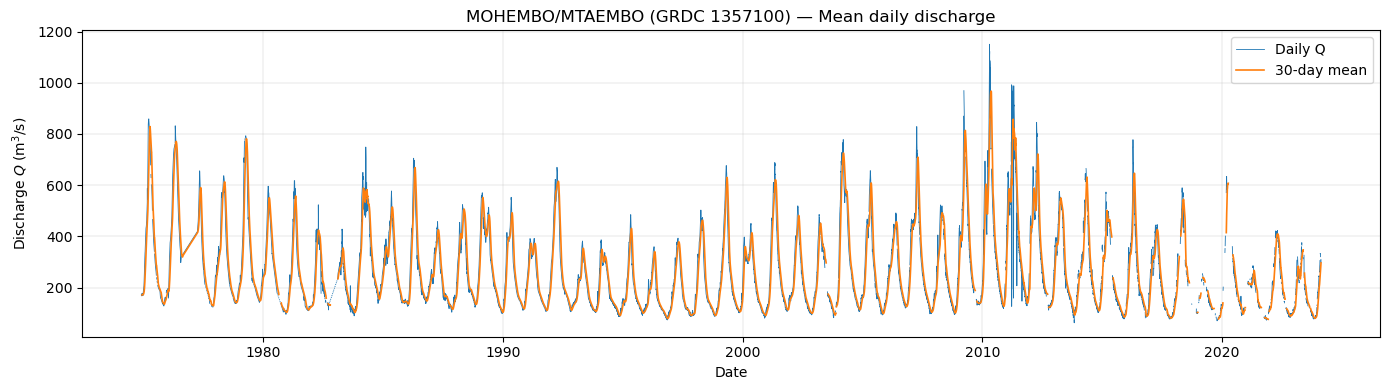

In [45]:
# Mohembo/Mtaembo (GRDC 1357100) — standalone notebook cell
from __future__ import annotations

from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------
# Config
# --------------------
DATA_DIR = Path("../GRDC_station_data")
FILE_NAME = "1357100_Q_Day.Cmd.txt"          # Mohembo/Mtaembo
OUT_DAILY_CSV = Path("../data/mohembo_1357100_Q_daily.csv")
OUT_MONTHLY_CSV = Path("../data/mohembo_1357100_Q_monthly_mean.csv")
META_RE = re.compile(r"^#\s*(?P<key>[^:]+):\s*(?P<val>.*)\s*$")

def _to_float(x) -> float:
    """Robust float parsing (handles commas/whitespace/None)."""
    if x is None:
        return np.nan
    s = str(x).strip().replace(",", ".")
    return pd.to_numeric(s, errors="coerce")


def _parse_filename(fp: Path) -> dict:
    """
    Many GRDC files look like: 1357100_Q_Day.Cmd.txt
    Extract station id + variable tag from filename when possible.
    """
    m = re.match(r"^(?P<id>\d+)_(?P<tag>.+?)\.Cmd\.txt$", fp.name)
    if not m:
        return {"file_station_id": np.nan, "file_tag": fp.stem}
    return {
        "file_station_id": pd.to_numeric(m.group("id"), errors="coerce"),
        "file_tag": m.group("tag"),
    }


def read_grdc_cmd_file(fp: str | Path, encoding: str = "latin-1") -> tuple[dict, pd.DataFrame]:
    """
    Read a GRDC *.Cmd.txt file.

    Returns
    -------
    meta : dict
        Metadata (raw + standardized fields)
    ts : pd.DataFrame
        Time series with DatetimeIndex and numeric data columns
    """
    fp = Path(fp)

    # --------- metadata (header) ----------
    meta_raw = {"source_file": fp.name, "source_path": str(fp)}
    meta_raw.update(_parse_filename(fp))

    with open(fp, "r", encoding=encoding, errors="replace") as f:
        for line in f:
            if not line.startswith("#"):
                continue
            m = META_RE.match(line)
            if m:
                meta_raw[m.group("key").strip()] = m.group("val").strip()

    # Standardize a few common keys (keep raw keys too)
    keymap = {
        "GRDC-No.": "grdc_no",
        "River": "river",
        "Station": "station_raw",
        "Country": "country",
        "Latitude (DD)": "lat",
        "Longitude (DD)": "lon",
        "Catchment area (km²)": "catchment_area_km2",
        "Catchment area (km�)": "catchment_area_km2",
        "Catchment area (km\xb2)": "catchment_area_km2",
        "Altitude (m ASL)": "altitude_m",
        "file generation date": "file_generation_date",
        "Last update": "last_update",
        "Data Set Content": "dataset_content",
        "Unit of measure": "unit",
        "Time series": "time_series",
        "Data lines": "data_lines",
    }

    meta = dict(meta_raw)
    for raw_k, std_k in keymap.items():
        if raw_k in meta_raw:
            meta[std_k] = meta_raw[raw_k]

    # Station name/code split like: "MOHEMBO/MTAEMBO (67932112)"
    if isinstance(meta.get("station_raw"), str):
        m = re.match(r"^(.*?)\s*\((.*?)\)\s*$", meta["station_raw"])
        if m:
            meta["station_name"] = m.group(1).strip()
            meta["station_code"] = m.group(2).strip()
        else:
            meta["station_name"] = meta["station_raw"].strip()

    # Numeric conversions
    if "grdc_no" in meta:
        meta["grdc_no"] = pd.to_numeric(str(meta["grdc_no"]).strip(), errors="coerce")
    for k in ("lat", "lon", "catchment_area_km2", "altitude_m"):
        if k in meta:
            meta[k] = _to_float(meta[k])
    if "data_lines" in meta:
        meta["data_lines"] = pd.to_numeric(str(meta["data_lines"]).strip(), errors="coerce")

    # --------- time series table ----------
    df = pd.read_csv(
        fp,
        sep=";",
        comment="#",
        skip_blank_lines=True,
        dtype=str,
        encoding=encoding,
    )

    # Clean column names + strip whitespace
    df.columns = [c.strip() for c in df.columns]
    for c in df.columns:
        df[c] = df[c].astype(str).str.strip()

    date_col = df.columns[0]
    time_col = df.columns[1] if len(df.columns) >= 2 else None

    # Parse datetime
    date = pd.to_datetime(df[date_col], format="%Y-%m-%d", errors="coerce")

    if time_col is not None:
        has_times = (~df[time_col].isin(["--:--", "--", "", "nan", "None"])).any()
        if has_times:
            t = df[time_col].replace({"--:--": "00:00", "--": "00:00", "": "00:00"})
            dt = pd.to_datetime(df[date_col] + " " + t, format="%Y-%m-%d %H:%M", errors="coerce")
        else:
            dt = date
    else:
        dt = date

    # Convert remaining columns to numeric; set missing flags to NaN
    drop_cols = [date_col] + ([time_col] if time_col is not None else [])
    data_cols = [c for c in df.columns if c not in drop_cols]

    out = df[data_cols].replace(
        {
            "-999.000": np.nan,
            "-999.00": np.nan,
            "-999.0": np.nan,
            "-999": np.nan,
            "": np.nan,
            "nan": np.nan,
            "None": np.nan,
        }
    )
    for c in data_cols:
        out[c] = pd.to_numeric(out[c], errors="coerce")

    out.insert(0, "datetime", dt)
    out = out.dropna(subset=["datetime"]).set_index("datetime").sort_index()

    return meta, out


def pick_discharge_column(ts: pd.DataFrame) -> str:
    """Pick the most likely discharge column from a GRDC table."""
    numeric_cols = [c for c in ts.columns if pd.api.types.is_numeric_dtype(ts[c])]
    if not numeric_cols:
        raise ValueError("No numeric columns found in time series table.")

    if len(numeric_cols) == 1:
        return numeric_cols[0]

    # Prefer columns named like discharge/Q/value
    for pat in [r"^\s*Q\s*$", r"discharge", r"\bflow\b", r"value"]:
        for c in numeric_cols:
            if re.search(pat, c, flags=re.IGNORECASE):
                return c

    # Fallback: first numeric column
    return numeric_cols[0]


# --------------------
# Load Mohembo + extract + save
# --------------------
fp = DATA_DIR / FILE_NAME
meta, ts = read_grdc_cmd_file(fp)

q_col = pick_discharge_column(ts)
ts = ts.rename(columns={q_col: "Q_m3s"})

# Add handy columns
ts = ts.assign(
    year=ts.index.year,
    month=ts.index.month,
    grdc_no=int(meta["grdc_no"]) if pd.notna(meta.get("grdc_no")) else np.nan,
    station=meta.get("station_name", "MOHEMBO/MTAEMBO"),
)

# Save daily series
ts[["Q_m3s", "year", "month", "grdc_no", "station"]].to_csv(OUT_DAILY_CSV, index_label="date")

# Save monthly mean series (calendar months)
monthly = ts["Q_m3s"].resample("MS").mean().to_frame("Q_m3s_monthly_mean")
monthly.to_csv(OUT_MONTHLY_CSV, index_label="month")

print(f"Station: {meta.get('station_name','')}, GRDC: {meta.get('grdc_no','')}, River: {meta.get('river','')}")
print(f"Lat/Lon: {meta.get('lat','')}, {meta.get('lon','')}")
print(f"Unit: {meta.get('unit','m^3/s')}, Time series: {meta.get('time_series','')}")
print(f"Daily rows: {len(ts):,} | Range: {ts.index.min().date()} → {ts.index.max().date()}")
print(f"Saved: {OUT_DAILY_CSV}")
print(f"Saved: {OUT_MONTHLY_CSV}")

# --------------------
# Plot (daily + 30-day mean)
# --------------------
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(ts.index, ts["Q_m3s"], linewidth=0.6, label="Daily Q")

q_30d = ts["Q_m3s"].rolling("30D", min_periods=10).mean()
ax.plot(q_30d.index, q_30d, linewidth=1.2, label="30-day mean")

title = f"{meta.get('station_name','MOHEMBO/MTAEMBO')} (GRDC {int(meta['grdc_no'])}) — Mean daily discharge"
ax.set_title(title)
ax.set_xlabel("Date")
ax.set_ylabel(r"Discharge $Q$ (m$^3$/s)")
ax.grid(True, linewidth=0.2)
ax.legend()

fig.tight_layout()
plt.show()



In [58]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd

# ----------------------------
# 0) Inputs / paths
# ----------------------------
# delta_shp = Path("../data/regions/Delta_UCB_WGS84/Delta_UCB_WGS84.shp")
mohembo_monthly_csv = Path("../data/mohembo_1357100_Q_monthly_mean.csv")  # from your notebook cell

# Delta area (m²) using equal-area projection
# delta_area_m2 = (
#     gpd.read_file(delta_shp)
#       .to_crs(epsg=6933)  # world equal-area
#       .geometry.area
#       .sum()
# )


def to_month_start(x):
    """Normalize datetimes to month-start for clean monthly merges."""
    x = pd.to_datetime(x)
    if isinstance(x, (pd.DatetimeIndex, pd.PeriodIndex)):
        return x.to_period("M").to_timestamp(how="start")
    return x.dt.to_period("M").dt.to_timestamp(how="start")

# ----------------------------
# 1) Mohembo inflow (monthly mean Q) -> monthly volumes (km³) + equivalent depth (mm)
# ----------------------------
q = pd.read_csv(mohembo_monthly_csv)

# file saved with index_label="month" OR may have a first column that is the month index
month_col = "month" if "month" in q.columns else q.columns[0]
q = q.rename(columns={month_col: "date"})
q["date"] = to_month_start(q["date"])

# column name from your notebook
q_col = "Q_m3s_monthly_mean"
if q_col not in q.columns:
    # fallback: pick the first numeric column
    q_col = q.select_dtypes(include="number").columns[0]

q = q.rename(columns={q_col: "Qin_m3s"})

# seconds in each month
seconds_in_month = (q["date"].dt.days_in_month * 24 * 3600).astype(float)

q["Qin_km3"] = q["Qin_m3s"] * seconds_in_month / 1e9
q["Qin_mm"]  = q["Qin_m3s"] * seconds_in_month / delta_area_m2 * 1000.0
q_mohembo = q[["date", "Qin_m3s", "Qin_km3", "Qin_mm"]].sort_values("date")

# ----------------------------
# 2) Build ONE master dataframe: ET + CHIRPS + GRACE + Mohembo
# ----------------------------
# Ensure datetime + normalize to month-start
df_et = df_all.copy()
df_et["date"] = to_month_start(df_et["date"])

df_p = df_chirps_monthly.copy()
df_p["date"] = to_month_start(df_p["date"])

df_g = df_grace.copy()
df_g["date"] = to_month_start(df_g["date"])

# If GRACE has multiple entries per month, collapse
df_g = df_g.groupby("date", as_index=False).mean(numeric_only=True)

# ET wide
et_mm  = df_et.pivot_table(index="date", columns="dataset", values="et_mm_mean",  aggfunc="mean").add_prefix("ETmm_")
et_km3 = df_et.pivot_table(index="date", columns="dataset", values="et_km3_total", aggfunc="mean").add_prefix("ETkm3_")

# Precip wide
p_mm  = df_p.pivot_table(index="date", columns="dataset", values="ppt_mm_mean",  aggfunc="mean").add_prefix("Pmm_")
p_km3 = df_p.pivot_table(index="date", columns="dataset", values="ppt_km3_total", aggfunc="mean").add_prefix("Pkm3_")

# GRACE (monthly anomaly over delta) -> indexed by month-start
grace = (df_g.set_index("date")[["grace_cm_mean", "grace_km3_total"]]
           .rename(columns={"grace_cm_mean": "GRACEcm_mean",
                            "grace_km3_total": "GRACEkm3_total"}))

# Combine (outer join on date index)
df_master = pd.concat([et_mm, et_km3, p_mm, p_km3, grace], axis=1).sort_index()

# ET medians (across products)
etmm_cols  = [c for c in df_master.columns if c.startswith("ETmm_")]
etkm3_cols = [c for c in df_master.columns if c.startswith("ETkm3_")]
df_master["ETmm_median"]  = df_master[etmm_cols].median(axis=1, skipna=True)
df_master["ETkm3_median"] = df_master[etkm3_cols].median(axis=1, skipna=True)

# Choose CHIRPS precip columns (first match containing CHIRPS; else first precip col)
pmm_cols  = [c for c in df_master.columns if c.startswith("Pmm_")]
pkm3_cols = [c for c in df_master.columns if c.startswith("Pkm3_")]
pmm_col  = next((c for c in pmm_cols  if "CHIRPS" in c.upper()),  (pmm_cols[0] if pmm_cols else None))
pkm3_col = next((c for c in pkm3_cols if "CHIRPS" in c.upper()), (pkm3_cols[0] if pkm3_cols else None))
df_master["Pmm"]  = df_master[pmm_col]  if pmm_col  else np.nan
df_master["Pkm3"] = df_master[pkm3_col] if pkm3_col else np.nan

# Storage change from GRACE (diff of anomaly) — safe only where GRACE exists
df_master["dS_km3"] = df_master["GRACEkm3_total"].diff()
df_master["dS_cm"]  = df_master["GRACEcm_mean"].diff()

# Mask GRACE diffs across big gaps (missing months)
gap_days = df_master.index.to_series().diff().dt.days
df_master.loc[gap_days > 45, ["dS_km3", "dS_cm"]] = np.nan

# Add Mohembo inflow (month-start alignment)
df_master = df_master.merge(q_mohembo.set_index("date"), left_index=True, right_index=True, how="left")

df_master

,ETmm_ERA5Land_totalET,ETmm_FLDAS_Evap,ETmm_MOD16A2GF_v61,ETmm_PML_v2_landET,ETmm_TerraClimate_aet,ETmm_USGS_SSEBop_MODIS_monthly,ETmm_WaPORv3_AETI_dekadal,ETkm3_ERA5Land_totalET,ETkm3_FLDAS_Evap,ETkm3_MOD16A2GF_v61,...,GRACEkm3_total,ETmm_median,ETkm3_median,Pmm,Pkm3,dS_km3,dS_cm,Qin_m3s,Qin_km3,Qin_mm
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,119.320636,109.476416,56.754732,0.000000,124.707942,NaN,NaN,38.751695,35.554594,18.432202,...,NaN,109.476416,35.554594,179.901455,58.426494,NaN,NaN,321.610000,0.861400,2.652344
2000-02-01,104.184302,112.422520,64.915015,23.007068,108.864255,NaN,NaN,33.835877,36.511398,21.082413,...,NaN,104.184302,33.835877,164.562437,53.444849,NaN,NaN,324.331379,0.812645,2.502220
2000-03-01,115.387445,110.828028,66.407764,99.346072,84.622984,NaN,NaN,37.474315,35.993556,21.567212,...,NaN,99.346072,32.264567,108.169226,35.130058,NaN,NaN,306.685161,0.821426,2.529258
2000-04-01,93.404011,74.518210,37.813600,70.783747,37.033633,NaN,NaN,30.334768,24.201237,12.280701,...,NaN,70.783747,22.988397,19.369572,6.290645,NaN,NaN,352.811000,0.914486,2.815801
2000-05-01,43.923626,27.314043,18.277825,24.634498,9.063979,NaN,NaN,14.265051,8.870766,5.936079,...,NaN,24.634498,8.000532,0.049501,0.016077,NaN,NaN,400.795484,1.073491,3.305393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-09-01,9.543724,2.385477,3.330841,0.000000,0.000000,NaN,44.168951,3.099510,0.774730,1.081755,...,NaN,2.858159,0.928243,0.576905,0.187361,NaN,NaN,NaN,NaN,NaN
2025-10-01,13.815556,7.815783,3.455617,0.000000,0.000000,NaN,51.910212,4.486870,2.538327,1.122279,...,NaN,5.635700,1.830303,11.062395,3.592728,NaN,NaN,NaN,NaN,NaN
2025-11-01,71.280638,41.916340,22.995617,0.000000,0.000000,NaN,63.848364,23.149772,13.613146,7.468274,...,NaN,32.455978,10.540710,50.658819,16.452436,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'km³ (anomaly)')

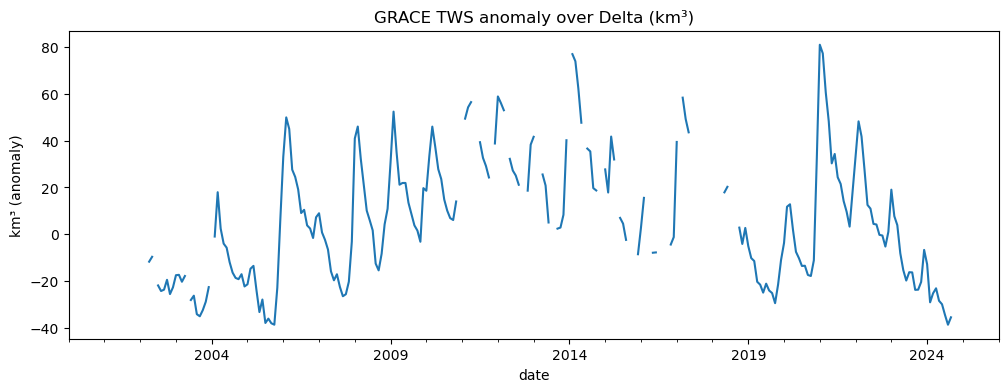

In [47]:
# ----------------------------
# 3) Mass-balance helper terms (control volume = Delta polygon)
# ----------------------------
# (Qout + G) implied by: dS = Qin + P - ET - (Qout + G)
df_master["Qout_plus_G_km3"] = df_master["Qin_km3"] + df_master["Pkm3"] - df_master["ETkm3_median"] - df_master["dS_km3"]
df_master["Qout_plus_G_mm"]  = df_master["Qin_mm"]  + df_master["Pmm"]  - df_master["ETmm_median"]  - (df_master["dS_cm"] * 10.0)

# Back to a normal column for plotting
df_master = df_master.reset_index().rename(columns={"index": "date"})

# Quick check plot
plt.figure(figsize = (12, 4))
ax = df_master.set_index("date")["GRACEkm3_total"].plot(title="GRACE TWS anomaly over Delta (km³)")
ax.set_ylabel("km³ (anomaly)")

dataset,ERA5Land_totalET,FLDAS_Evap,MOD16A2GF_v61,USGS_SSEBop_MODIS_monthly,WaPORv3_AETI_dekadal
date,,,,,
2000-01-01,119.320636,109.476416,56.754732,NaN,NaN
2000-02-01,104.184302,112.422520,64.915015,NaN,NaN
2000-03-01,115.387445,110.828028,66.407764,NaN,NaN
2000-04-01,93.404011,74.518210,37.813600,NaN,NaN
2000-05-01,43.923626,27.314043,18.277825,NaN,NaN
...,...,...,...,...,...
2025-09-01,9.543724,2.385477,3.330841,NaN,44.168951
2025-10-01,13.815556,7.815783,3.455617,NaN,51.910212
2025-11-01,71.280638,41.916340,22.995617,NaN,63.848364


In [71]:
import numpy as np
import pandas as pd

def to_month_start(x):
    """Normalize datetimes to month-start (avoids GRACE vs ET/CHIRPS merge mismatch)."""
    x = pd.to_datetime(x)
    return x.dt.to_period("M").dt.to_timestamp(how="start")

# --- normalize all dates to month-start (CRITICAL) ---
df_all = df_all.copy()
df_chirps_monthly = df_chirps_monthly.copy()
df_grace = df_grace.copy()
q_mohembo = q_mohembo.copy()

df_all["date"] = to_month_start(df_all["date"])
df_chirps_monthly["date"] = to_month_start(df_chirps_monthly["date"])
df_grace["date"] = to_month_start(df_grace["date"])
q_mohembo["date"] = to_month_start(q_mohembo["date"])

# If any duplicates within a month, collapse
df_all = df_all.groupby(["date", "dataset"], as_index=False).mean(numeric_only=True)
df_chirps_monthly = df_chirps_monthly.groupby(["date", "dataset"], as_index=False).mean(numeric_only=True)
df_grace = df_grace.groupby("date", as_index=False).mean(numeric_only=True)
q_mohembo = q_mohembo.groupby("date", as_index=False).mean(numeric_only=True)

# -----------------------
# 1) ET ensemble median
# -----------------------
et_mm_wide  = df_all.pivot_table(index="date", columns="dataset", values="et_mm_mean",  aggfunc="median").sort_index()
et_km3_wide = df_all.pivot_table(index="date", columns="dataset", values="et_km3_total", aggfunc="median").sort_index()

et_km3_wide = et_km3_wide.drop(['TerraClimate_aet', 'PML_v2_landET'], axis = 1)
ETmm_med  = et_mm_wide.median(axis=1, skipna=True).rename("ETmm")
ETkm3_med = et_km3_wide.median(axis=1, skipna=True).rename("ETkm3")

# -----------------------
# 2) CHIRPS precip
# -----------------------
p_mm_wide  = df_chirps_monthly.pivot_table(index="date", columns="dataset", values="ppt_mm_mean",  aggfunc="median").sort_index()
p_km3_wide = df_chirps_monthly.pivot_table(index="date", columns="dataset", values="ppt_km3_total", aggfunc="median").sort_index()

if p_mm_wide.shape[1] == 0 or p_km3_wide.shape[1] == 0:
    raise ValueError("No precip columns found in df_chirps_monthly after pivot. Check 'dataset' values/bands.")

pmm_col  = next((c for c in p_mm_wide.columns  if "CHIRPS" in str(c).upper()),  p_mm_wide.columns[0])
pkm3_col = next((c for c in p_km3_wide.columns if "CHIRPS" in str(c).upper()), p_km3_wide.columns[0])

Pmm  = p_mm_wide[pmm_col].rename("Pmm")
Pkm3 = p_km3_wide[pkm3_col].rename("Pkm3")

# -----------------------
# 3) GRACE storage anomaly + monthly change (with gap checks)
# -----------------------
gr = (df_grace.set_index("date")[["grace_cm_mean", "grace_km3_total"]]
      .sort_index()
      .rename(columns={"grace_cm_mean": "GRACEcm", "grace_km3_total": "GRACEkm3"}))

# sanity: GRACE should now be month-start
bad_grace_dates = gr.index[gr.index.day != 1]
if len(bad_grace_dates) > 0:
    raise ValueError(f"GRACE dates not normalized to month-start (day!=1). Example: {bad_grace_dates[:5].tolist()}")

dS_km3 = gr["GRACEkm3"].diff().rename("dS_km3")
dS_cm  = gr["GRACEcm"].diff().rename("dS_cm")

gap_days = gr.index.to_series().diff().dt.days
# flag likely missing-month gaps
if (gap_days > 45).any():
    n_gaps = int((gap_days > 45).sum())
    print(f"Warning: {n_gaps} GRACE gaps >45 days; setting dS to NaN across those steps.")

dS_km3[gap_days > 45] = np.nan
dS_cm[gap_days > 45]  = np.nan

# -----------------------
# 4) Qin (Mohembo) + mass-balance terms
# -----------------------
qin = (q_mohembo.set_index("date")[["Qin_m3s", "Qin_km3", "Qin_mm"]]
       .sort_index())

# sanity: Qin should be month-start
bad_qin_dates = qin.index[qin.index.day != 1]
if len(bad_qin_dates) > 0:
    raise ValueError(f"Qin dates not normalized to month-start (day!=1). Example: {bad_qin_dates[:5].tolist()}")

df_balance = pd.concat([Pmm, Pkm3, ETmm_med, ETkm3_med, gr, dS_km3, dS_cm, qin], axis=1).sort_index()

# -----------------------
# 5) Error / closure checks
# -----------------------
# implied (Qout + net groundwater export):
df_balance["Qout_plus_G_km3"] = df_balance["Qin_km3"] + df_balance["Pkm3"] - df_balance["ETkm3"] - df_balance["dS_km3"]
df_balance["Qout_plus_G_mm"]  = df_balance["Qin_mm"]  + df_balance["Pmm"]  - df_balance["ETmm"]  - (df_balance["dS_cm"] * 10.0)

# convenience: months where you can actually compute closure (need Qin, P, ET, and dS)
df_balance["has_closure"] = df_balance[["Qin_km3", "Pkm3", "ETkm3", "dS_km3"]].notna().all(axis=1)

# a residual definition (should be ~0 if you later include Qout and G separately)
# residual = dS - (Qin + P - ET - (Qout+G)) ; since Qout+G is implied here, residual is identically 0 where defined.
# But we can check for impossible values:
bad = df_balance.loc[df_balance["has_closure"] & (df_balance["Qout_plus_G_km3"] < 0)]
if len(bad) > 0:
    print(f"Note: {len(bad)} months have negative implied (Qout+G). "
          "Could be storage/ET/P bias, timing mismatch, or true net inflow > outflow+G not holding for your control volume.")

df_balance.reset_index().rename(columns={"index": "date"})

# Add this at the very end (after df_balance is created)

df_balance = df_balance.loc[df_balance.index.year > 2000].copy()
df_balance.reset_index().rename(columns={"index": "date"})

Note: 88 months have negative implied (Qout+G). Could be storage/ET/P bias, timing mismatch, or true net inflow > outflow+G not holding for your control volume.


,date,Pmm,Pkm3,ETmm,ETkm3,GRACEcm,GRACEkm3,dS_km3,dS_cm,Qin_m3s,Qin_km3,Qin_mm,Qout_plus_G_km3,Qout_plus_G_mm,has_closure
0,2001-01-01,26.868823,8.726172,70.341635,17.491432,NaN,NaN,NaN,NaN,126.584839,0.339045,1.043955,NaN,NaN,False
1,2001-02-01,141.289900,45.886641,92.937095,28.825814,NaN,NaN,NaN,NaN,208.253929,0.503808,1.551279,NaN,NaN,False
2,2001-03-01,67.463386,21.910046,95.789022,31.109346,NaN,NaN,NaN,NaN,418.136452,1.119937,3.448405,NaN,NaN,False
3,2001-04-01,57.583066,18.701220,63.088410,20.489187,NaN,NaN,NaN,NaN,560.929333,1.453929,4.476803,NaN,NaN,False
4,2001-05-01,0.181202,0.058849,24.834050,8.065340,NaN,NaN,NaN,NaN,590.478065,1.581536,4.869721,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,2025-09-01,0.576905,0.187361,2.858159,2.090633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
297,2025-10-01,11.062395,3.592728,5.635700,3.512599,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
298,2025-11-01,50.658819,16.452436,32.455978,17.174571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
299,2025-12-01,194.445719,63.150026,72.051274,29.225389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


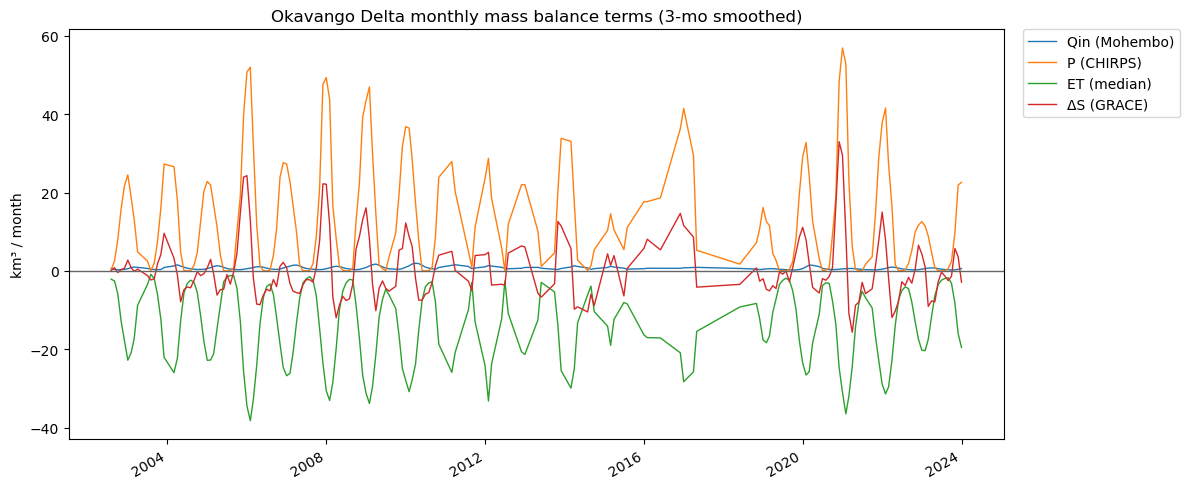

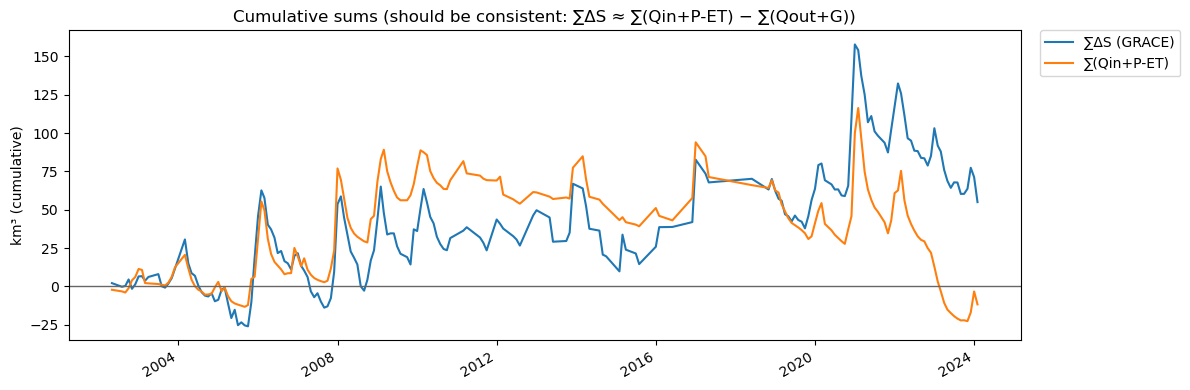

In [66]:
import matplotlib.pyplot as plt

# --- use only months where closure is possible ---
dfc = df_balance[df_balance["has_closure"]].copy()

# -----------------------
# Plot 1: Terms in km³/month (bar-style)
# dS = Qin + P - ET - (Qout+G)
# -----------------------
terms = dfc[["Qin_km3", "Pkm3", "ETkm3", "dS_km3", "Qout_plus_G_km3"]].copy()
# Make all "inflows" positive and all "outflows" negative for easy visual sum
plot_terms = pd.DataFrame(index=terms.index)
plot_terms["Qin (Mohembo)"] = terms["Qin_km3"]
plot_terms["P (CHIRPS)"]    = terms["Pkm3"]
plot_terms["ET (median)"]   = - terms["ETkm3"]
plot_terms["ΔS (GRACE)"]    = terms["dS_km3"]          # can be ±
# plot_terms["-(Qout+G)"]     = -terms["Qout_plus_G_km3"]  # shown as an outflow

fig, ax = plt.subplots(figsize=(12, 5))
plot_terms.rolling(3, center=True).mean().plot(ax=ax, linewidth=1)  # 3-mo smooth
ax.axhline(0, lw=1, c="0.4")
ax.set_title("Okavango Delta monthly mass balance terms (3-mo smoothed)")
ax.set_ylabel("km³ / month")
ax.set_xlabel("")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()


# -----------------------
# Plot 3: Cumulative anomalies (integrate monthly terms; km³)
# -----------------------
cum = pd.DataFrame(index=dfc.index)
cum["∑ΔS (GRACE)"] = dfc["dS_km3"].cumsum()
cum["∑(Qin+P-ET)"] = (dfc["Qin_km3"] + dfc["Pkm3"] - dfc["ETkm3"]).cumsum()
# cum["∑(Qout+G)"]   = dfc["Qout_plus_G_km3"].cumsum()

fig, ax = plt.subplots(figsize=(12, 4))
cum.plot(ax=ax, linewidth=1.5)
ax.axhline(0, lw=1, c="0.4")
ax.set_title("Cumulative sums (should be consistent: ∑ΔS ≈ ∑(Qin+P-ET) − ∑(Qout+G))")
ax.set_ylabel("km³ (cumulative)")
ax.set_xlabel("")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

Plotting 4 ET products (coverage >= 70%).


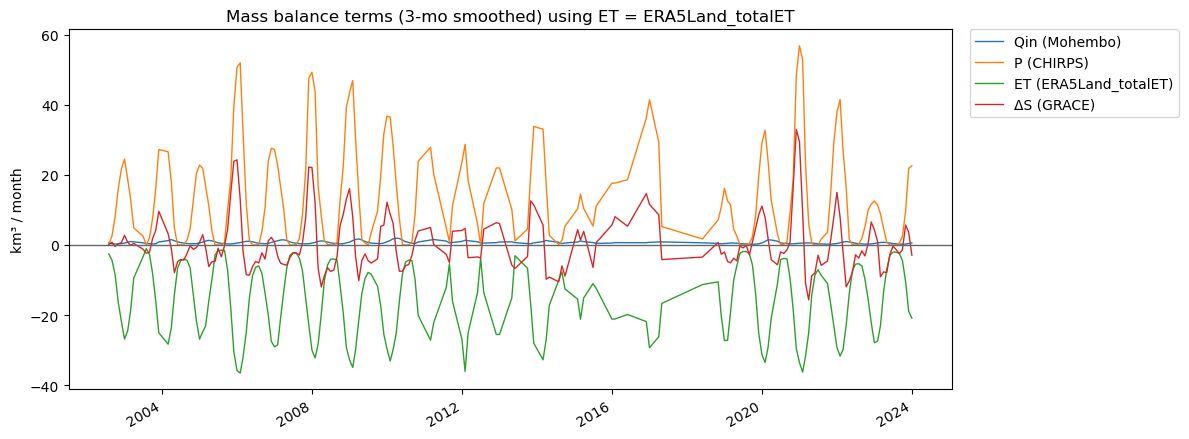

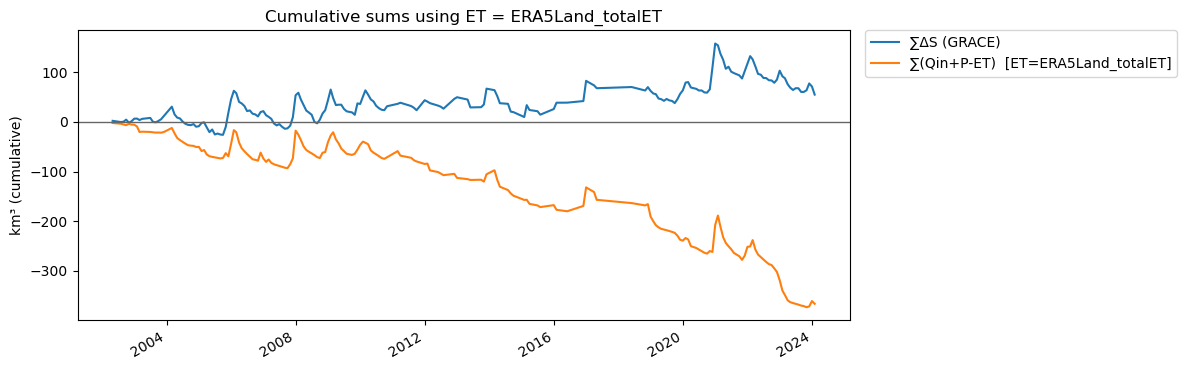

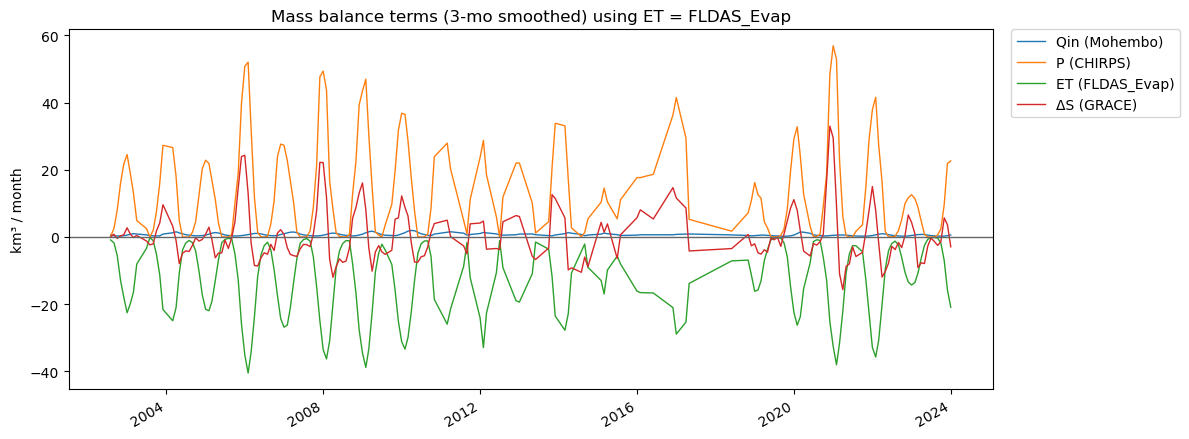

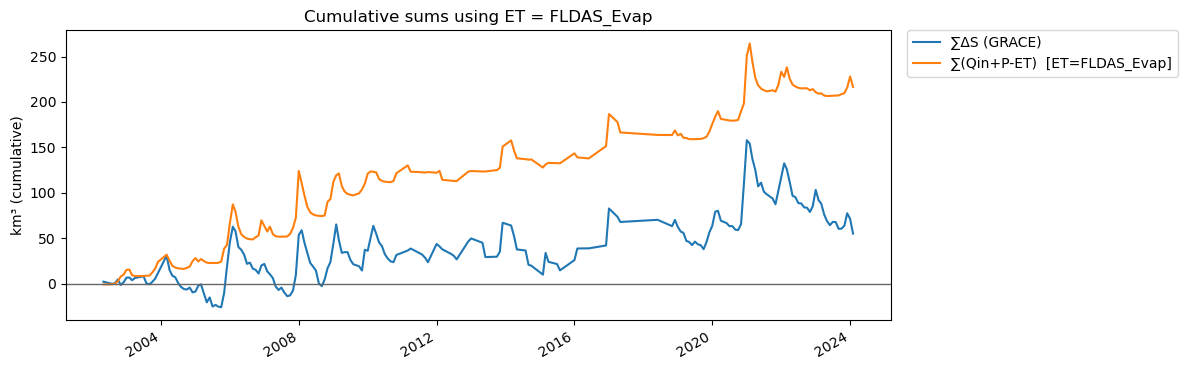

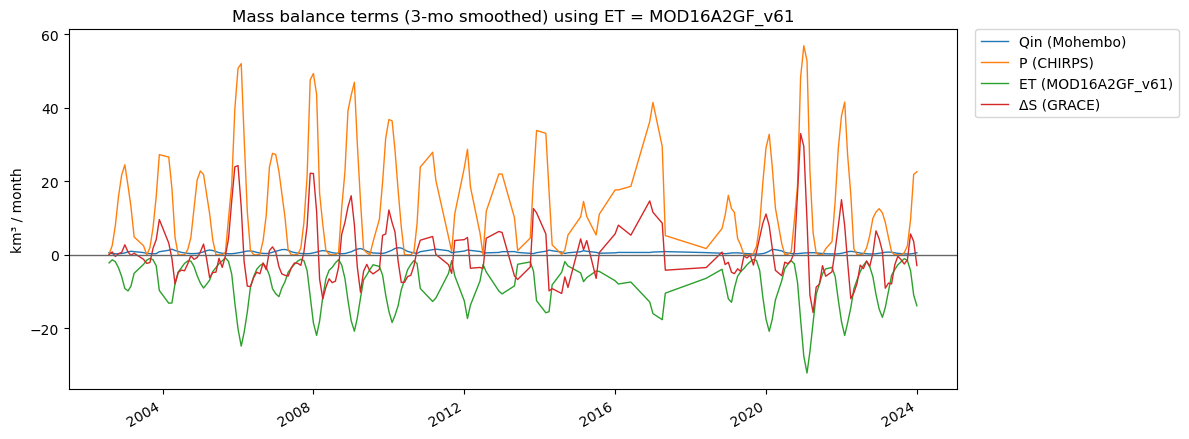

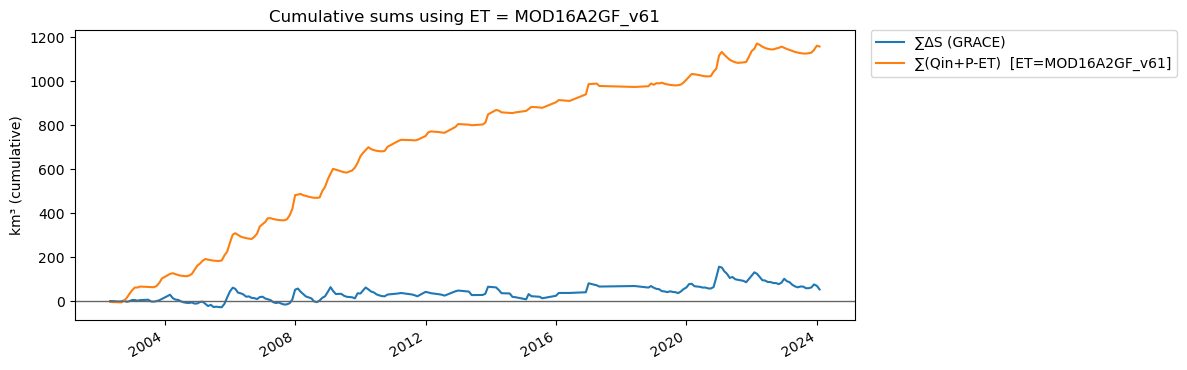

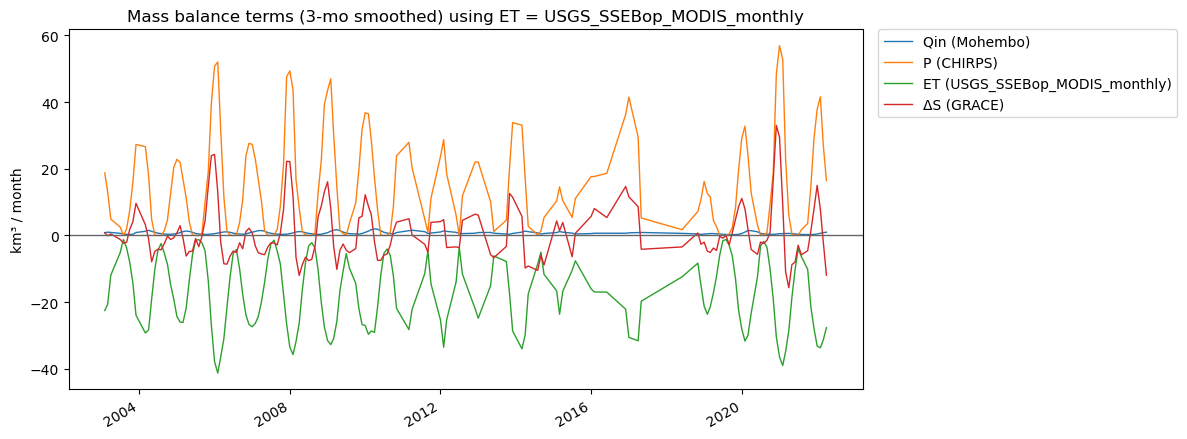

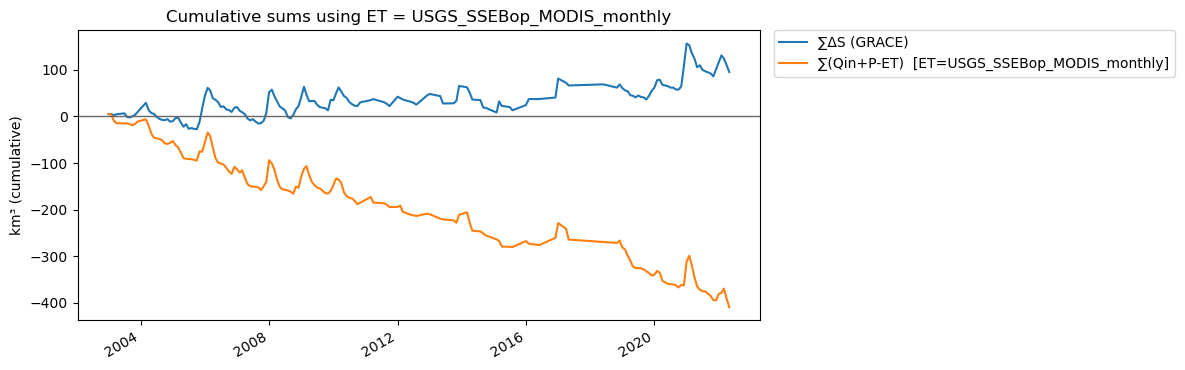

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- months where closure is possible for non-ET terms (Qin, P, dS must exist) ---
base_mask = df_balance[["Qin_km3", "Pkm3", "dS_km3"]].notna().all(axis=1)
dfc_base = df_balance.loc[base_mask].copy()

# --- identify ET ensemble columns (wide table assumed to exist) ---
# Preferred: use the wide ET table you already created earlier (et_km3_wide)
# If it doesn't exist, rebuild from df_all:
try:
    et_km3_wide
except NameError:
    et_km3_wide = (df_all.pivot_table(index="date", columns="dataset", values="et_km3_total", aggfunc="mean")
                        .sort_index())

# Align ET columns to df_balance index and keep only those with enough coverage
et_km3_wide = et_km3_wide.reindex(dfc_base.index)

min_frac = 0.7  # require >=70% non-NaN in the plotted window
keep = (et_km3_wide.notna().mean() >= min_frac)
et_cols = et_km3_wide.columns[keep].tolist()

print(f"Plotting {len(et_cols)} ET products (coverage >= {int(min_frac*100)}%).")

for et_name in et_cols:
    dfc = dfc_base.copy()
    dfc["ETkm3_model"] = et_km3_wide[et_name]

    # mask to months where THIS ET product exists
    dfc = dfc[dfc["ETkm3_model"].notna()].copy()

    # --- Plot 1: monthly terms (3-mo smooth) ---
    plot_terms = pd.DataFrame(index=dfc.index)
    plot_terms["Qin (Mohembo)"] = dfc["Qin_km3"]
    plot_terms["P (CHIRPS)"]    = dfc["Pkm3"]
    plot_terms[f"ET ({et_name})"] = -dfc["ETkm3_model"]
    plot_terms["ΔS (GRACE)"]    = dfc["dS_km3"]

    fig, ax = plt.subplots(figsize=(12, 4.5))
    plot_terms.rolling(3, center=True).mean().plot(ax=ax, linewidth=1)
    ax.axhline(0, lw=1, c="0.4")
    ax.set_title(f"Mass balance terms (3-mo smoothed) using ET = {et_name}")
    ax.set_ylabel("km³ / month")
    ax.set_xlabel("")
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: cumulative comparison ---
    cum = pd.DataFrame(index=dfc.index)
    cum["∑ΔS (GRACE)"] = dfc["dS_km3"].cumsum()
    cum[f"∑(Qin+P-ET)  [ET={et_name}]"] = (dfc["Qin_km3"] + dfc["Pkm3"] - dfc["ETkm3_model"]).cumsum()

    fig, ax = plt.subplots(figsize=(12, 3.8))
    cum.plot(ax=ax, linewidth=1.5)
    ax.axhline(0, lw=1, c="0.4")
    ax.set_title(f"Cumulative sums using ET = {et_name}")
    ax.set_ylabel("km³ (cumulative)")
    ax.set_xlabel("")
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.tight_layout()
    plt.show()